In [1]:
from google.colab import drive
drive.mount('/content/drive') # 구글 드라이브에 있는 데이터 가져오기 위해 dirve.mount

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
# 데이터가 변조 되었을 때 모델이 잘 캐치할 수 있도록 케라스에서 제공하는 이미지 제네레이터 사용
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

rootPath = 'drive/MyDrive/sunglasses_data_5' # 구글 드라이브에 있는 데이터의 위치를 지정

In [3]:
imageGenerator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    brightness_range=[.2,.2],
                                    horizontal_flip=True,
                                    validation_split=.1)

# rescale 이미지 크기 조율
# rotation_range 지정된 각도 범위에서 임의로 이미지 회전
# width_shift_range 지정된 수평방향 내에서 임의로 이미지 좌우 이동
# height_shift_range 지정된 수직방향 내에서 임의로 이미지 상하 이동
# brightness_range 이미지 밝기 랜덤 부여
# horizontal_filp 이미지 수평방향으로 뒤집기
# validation_split 주어진 데이터셋을 test와 traning으로 나누는 비율

flow_from_directory 함수 사용해 driectory를 불러와 traning set과 validation set 나눈다

In [4]:
trainGen = imageGenerator.flow_from_directory(os.path.join(rootPath,'training_set'), target_size=(64,64), subset='training')
validationGen = imageGenerator.flow_from_directory(os.path.join(rootPath,'training_set'), target_size=(64,64), subset='validation')

# target_size로 이미지 64*64 사이즈 읽어온다
# subset 위에서 validation_split로 지정한 비율만큼 이미지 가져온다

Found 271 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# 모델 생성
model = Sequential()

In [6]:
model.add(layers.InputLayer(input_shape=(64,64,3)))
model.add(layers.Conv2D(16,(3,3),(1,1),'same',activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Conv2D(32, (3, 3), (1, 1), 'same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Conv2D(64, (3, 3), (1, 1), 'same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.3))

# Layers 사용해 inputLayer에 읽어 온 64*64 이미지 정보를 준다
# Conv2D를 사용해 16개의 3*3 Convolution fiter를 적용함
# MaxPooling은 2*2 사이즈로 수행
# Dropout 비율 0.3으로 설정

In [7]:
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

# convolution과 pooling이 진행되면서 주요 특징이 추출된다 (CNN)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [8]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['acc'],
)

# model의 compile 함수를 사용해서 어떻게 학습을 시킬 것인지 설정한다
# 최적화 함수 = adam, 착용, 미착용의 분류를 하는 문제이므로 loss = binary_crosseentropy, 정확도 계산

In [11]:
epochs = 30
history = model.fit(
    trainGen,
    steps_per_epoch=int(trainGen.samples / epochs),
    epochs=epochs,
    validation_data=validationGen,
    validation_steps=int(trainGen.samples / epochs))


Epoch 1/30
9/9 [==============================] - 2s 272ms/step - loss: 0.6906 - acc: 0.5867 - val_loss: 0.6910 - val_acc: 0.7333
Epoch 2/30
9/9 [==============================] - 2s 217ms/step - loss: 0.6894 - acc: 0.5387
Epoch 3/30
9/9 [==============================] - 2s 208ms/step - loss: 0.6699 - acc: 0.6125
Epoch 4/30
9/9 [==============================] - 2s 205ms/step - loss: 0.7179 - acc: 0.5424
Epoch 5/30
9/9 [==============================] - 2s 199ms/step - loss: 0.6688 - acc: 0.6162
Epoch 6/30
9/9 [==============================] - 2s 208ms/step - loss: 0.6134 - acc: 0.6937
Epoch 7/30
9/9 [==============================] - 2s 207ms/step - loss: 0.5887 - acc: 0.7232
Epoch 8/30
9/9 [==============================] - 2s 217ms/step - loss: 0.5403 - acc: 0.7417
Epoch 9/30
9/9 [==============================] - 2s 214ms/step - loss: 0.5124 - acc: 0.7491
Epoch 10/30
9/9 [==============================] - 2s 215ms/step - loss: 0.4611 - acc: 0.7565
Epoch 11/30
9/9 [===============

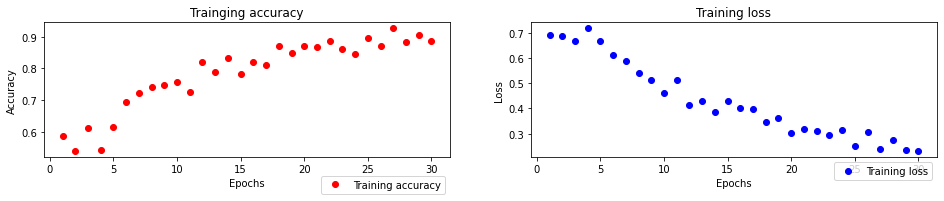

In [12]:
import matplotlib.pyplot as plt

# 정확도와 손실 값 출력
def show_graph(history_dict):
    accuracy = history_dict['acc']
    val_accuracy = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(16, 1))
    
    plt.subplot(121)
    plt.subplots_adjust(top=2)
    plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
    #plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Trainging accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=5)
    plt.legend(bbox_to_anchor=(1, -0.1))

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    #plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
    plt.legend(bbox_to_anchor=(1, 0))

    plt.show()

show_graph(history.history)


In [13]:
testGenerator = ImageDataGenerator(
    rescale=1./255
)

testGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'test_set'),
    target_size=(64, 64),
)

model.evaluate_generator(testGen)

# 테스트 데이터도 generator를 이용해서 imageGenerator 생성

Found 79 images belonging to 2 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.8965091705322266, 0.5822784900665283]

예측: 미착용
정답: 미착용


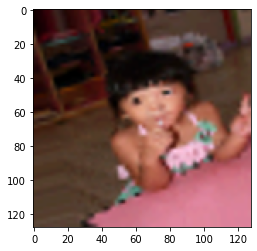

In [23]:
from tensorflow.keras.preprocessing.image import array_to_img
import numpy as np

# 테스트 데이터 모델 예측하기
cls_index = ['미착용', '착용']

imgs = testGen.next()
arr = imgs[0][0]
img = array_to_img(arr).resize((128, 128))
plt.imshow(img)
result = model.predict_classes(arr.reshape(1, 64, 64, 3))
print('예측: {}'.format(cls_index[result[0]]))
print('정답: {}'.format(cls_index[np.argmax(imgs[1][0])]))